In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from math import sin, cos, pi
from scipy.optimize import approx_fprime
from collections import namedtuple
Params = namedtuple('Params', ['m1', 'm2', 'L1', 'L2', 'g'])

import os
import sys
notebook_dir = os.getcwd()
sys.path.insert(0, notebook_dir)

## Python Warmup

Just like Julia, Python lets you do the following:

In [2]:
x = np.array([1, 2, 3])
print(x)
y = x # NEVER DO THIS, EDITING ONE WILL NOW EDIT BOTH 

y[2] = 100 # this will now modify both y and x
x[0] = 300 # this will now modify both y and x

print(y)
print(x)

[1 2 3]
[300   2 100]
[300   2 100]


In [3]:
x = np.array([1, 2, 3])
print(x)

y1 = 1*x         # this is fine 
y2 = copy.deepcopy(x) # this is also fine 

x[1] = 200 # only edits x 
y1[0] = 400 # only edits y1 
y2[2] = 100 # only edits y2 

print(x)
print(y1)
print(y2)

[1 2 3]
[  1 200   3]
[400   2   3]
[  1   2 100]


### Optional function arguments

We can have optional keyword arguments for functions in Python, like the following:

In [4]:
## optional arguments in functions 

# we can have functions with optional arguments after a ; that have default values 
def f1(a, b, c=4, d=5):
    print(a, b, c, d)

f1(1,2)               # this means c and d will take on default value 
f1(1,2, c = 100, d = 2) # specify c and d 
f1(1,2, d = -30)       # or we can only specify one of them 

1 2 4 5
1 2 100 2
1 2 4 -30


## Q1: Integration (25 pts)
In this question we are going to integrate the equations of motion for a double pendulum using multiple explicit and implicit integrators. We will write a generic simulation function for each of the two categories (explicit and implicit), and compare 6 different integrators.

The continuous time dynamics of the cartpole are written as a function:

$$\dot{x} = f(x)$$

In the code you will see `xdot = dynamics(params, x)`.

### Part A (10 pts): Explicit Integration
Here we are going to implement the following explicit integrators:
- Forward Euler (explicit)
- Midpoint (explicit)
- RK4 (explicit)

In [5]:
# these two functions are given, no TODO's here 
def double_pendulum_dynamics(params, x):
    # continuous time dynamics for a double pendulum given state x,
    # also known as the "equations of motion". 
    # returns the time derivative of the state, ẋ (dx/dt)

    # the state is the following:
    theta_1, omega_1, theta_2, omega_2 = x

    # system parameters
    m1, m2, L1, L2, g = params.m1, params.m2, params.L1, params.L2, params.g

    # dynamics
    c = cos(theta_1-theta_2)
    s = sin(theta_1-theta_2)

    dot_x = np.array([
        omega_1,
        ( m2*g*sin(theta_2)*c - m2*s*(L1*c*omega_1**2 + L2*omega_2**2) - (m1+m2)*g*sin(theta_1) ) / (L1*(m1 + m2*s**2)),
        omega_2,
        ((m1+m2)*(L1*omega_1**2*s - g*sin(theta_2) + g*sin(theta_1)*c) + m2*L2*omega_2**2*s*c) / (L2*(m1 + m2*s**2)),
    ])

    return dot_x

def double_pendulum_energy(params, x):
    # calculate the total energy (kinetic + potential) of a double pendulum given a state x 

    # the state is the following:
    theta_1, omega_1, theta_2, omega_2 = x

    # system parameters
    m1, m2, L1, L2, g = params.m1, params.m2, params.L1, params.L2, params.g

    # cartesian positions/velocities of the masses
    r1 = np.array([L1*sin(theta_1), 0, -L1*cos(theta_1) + 2])
    r2 = r1 + np.array([L2*sin(theta_2), 0, -L2*cos(theta_2)])
    v1 = np.array([L1*omega_1*cos(theta_1), 0, L1*omega_1*sin(theta_1)])
    v2 = v1 + np.array([L2*(omega_2)*cos(theta_2), 0, L2*(omega_2)*sin(theta_2)])

    # energy calculation
    kinetic = 0.5*(m1*np.dot(v1, v1) + m2*np.dot(v2, v2))
    potential = m1*g*r1[2] + m2*g*r2[2]
    return kinetic + potential

Now we are going to simulate this double pendulum by integrating the equations of motion with the simplest explicit integrator, the Forward Euler method:

$$x_{k+1} = x_k + \Delta t \cdot f({x}_k) \quad \quad \text{Forward Euler (explicit)}$$

In [6]:
"""
    x_{k+1} = forward_euler(params, dynamics, x_k, dt)

Given `ẋ = dynamics(params, x)`, take in the current state `x` and integrate it forward `dt`
using Forward Euler method. 
"""
def forward_euler(params, dynamics, x, dt):
    # ẋ = dynamics(params, x)
    # TODO: implement forward euler
    ret = dynamics(params, x)*dt + x
    return ret

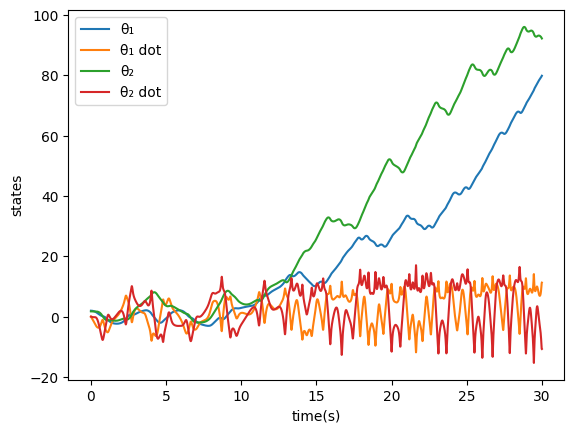

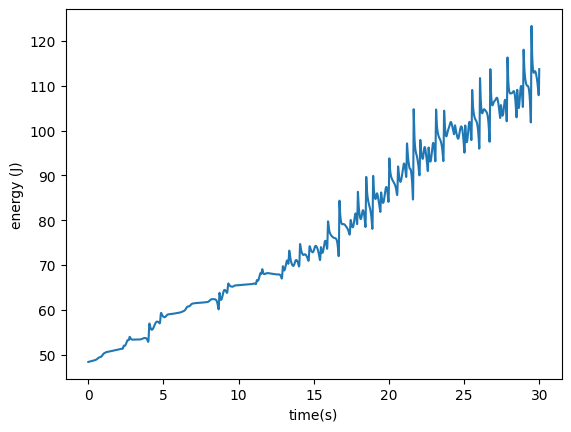

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [7]:
from animation import meshcat_animate

def plot_states(t_vec, X):
    plt.figure()
    plt.plot(t_vec, X[:,0], label='θ₁')
    plt.plot(t_vec, X[:,1], label='θ̇₁ dot')
    plt.plot(t_vec, X[:,2], label='θ₂')
    plt.plot(t_vec, X[:,3], label='θ₂ dot')
    plt.legend()
    plt.xlabel('time(s)')
    plt.ylabel('states')
    plt.show()

def plot_energy(t_vec, E):
    plt.figure()
    plt.plot(t_vec, E)
    plt.xlabel('time(s)')
    plt.ylabel('energy (J)')
    plt.show()

# @testset "forward euler"

# parameters for the simulation
params = Params(
    m1 = 1.0,
    m2 = 1.0,
    L1 = 1.0,
    L2 = 1.0,
    g = 9.8
)

# initial condition
x0 = np.array([pi/1.6, 0., pi/1.8, 0.])

# time step size (s)
dt = 0.01
tf = 30.0 
t_vec = np.arange(0, tf, dt)
N = len(t_vec)

# store the trajectory in a vector of vectors
X = np.zeros(shape=(N,4))
X[0] = x0

# TODO: simulate the double pendulum with `forward_euler` 
# X[k] = `x_k`, so X[k+1] = forward_euler(params, double_pendulum_dynamics, X[k], dt)
for k in range(N-1):
    X[k+1] = forward_euler(params, double_pendulum_dynamics, X[k], dt)

# calculate energy 
E = [double_pendulum_energy(params, x) for x in X]

assert np.linalg.norm(X[-1], ord=2) > 1e-10   # make sure all X's were updated
assert 2 < (E[-1]/E[0]) < 3  # energy should be increasing

# plot state history, energy history, and animate it
#display(plot(t_vec, hcat(X...)',xlabel = "time (s)", label = ["θ₁" "θ̇₁ dot" "θ₂" "θ̇₂ dot"]))
#display(plot(t_vec, E, xlabel = "time (s)", ylabel = "energy (J)"))
#meshcat_animate(params,X,dt,N)

plot_states(t_vec, X)
plot_energy(t_vec, E)
meshcat_animate(params, X, dt, N)

Now let's implement the next two integrators:

**Midpoint:**
$$ \begin{align} x_m &= x_k + \frac{\Delta t}{2} \cdot f(x_k) \\
    x_{k+1} &= x_k + \Delta t \cdot f({x}_m)\end{align}$$

**RK4:**
$$\begin{align}k_1 &= \Delta t \cdot f({x}_k) \\
    k_2 &= \Delta t \cdot f(x_k + k_1/2)  \\
    k_3 &= \Delta t \cdot f(x_k + k_2/2)  \\
    k_4 &= \Delta t \cdot f(x_k + k_3)  \\
    x_{k+1} &= x_k + (1/6)\cdot (k_1 + 2k_2 + 2k_3 + k_4)\end{align} $$

In [8]:
def midpoint(params, dynamics, x, dt):
    # TODO: implement explicit midpoint
    x_mid = x + dynamics(params, x)*dt/2
    return x + dynamics(params, x_mid)*dt

def rk4(params, dynamics, x, dt):
    # TODO: implement RK4
    k1 = dynamics(params, x)
    k2 = dynamics(params, x + k1*dt/2)
    k3 = dynamics(params, x + k2*dt/2)
    k4 = dynamics(params, x + k3*dt)
    return x + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

In [9]:
def simulate_explicit(params, dynamics, integrator, x0, dt, tf):
    # TOOD: update this function to simulate dynamics forward
    # with the given explicit integrator 

    # take in 
    t_vec = np.arange(0, tf, dt)
    N = len(t_vec)
    X = np.zeros(shape=(N,len(x0)))
    X[0] = x0

    # TODO: simulate X forward
    for k in range(N-1):
        X[k+1] = integrator(params, dynamics, X[k], dt)

    # return state history X and energy E 
    E = [double_pendulum_energy(params, x) for x in X]
    return X, E

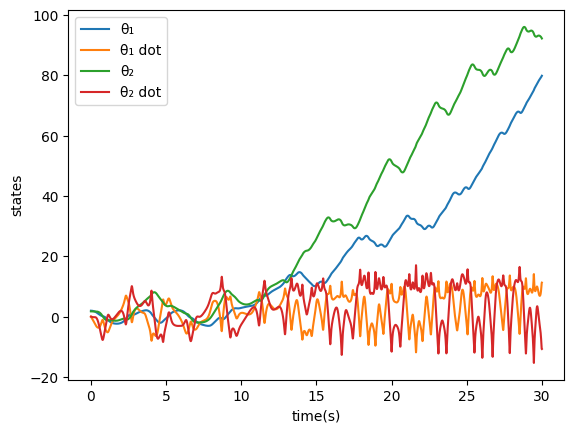

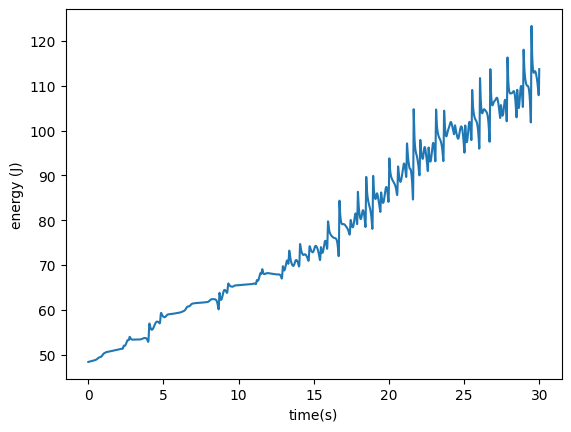

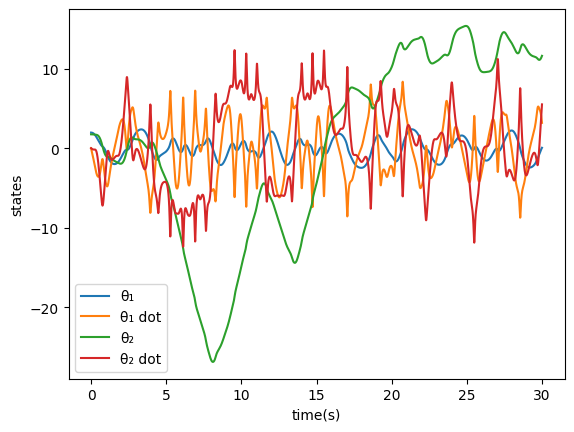

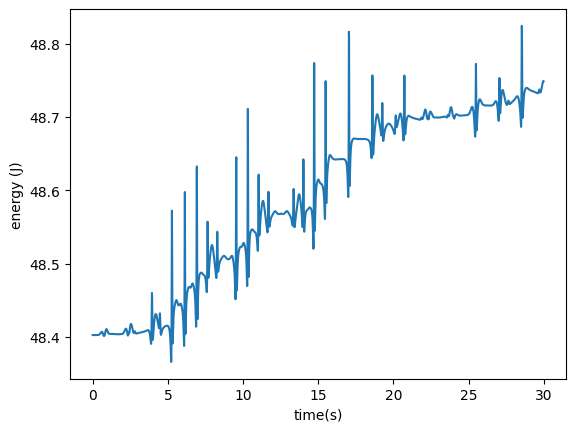

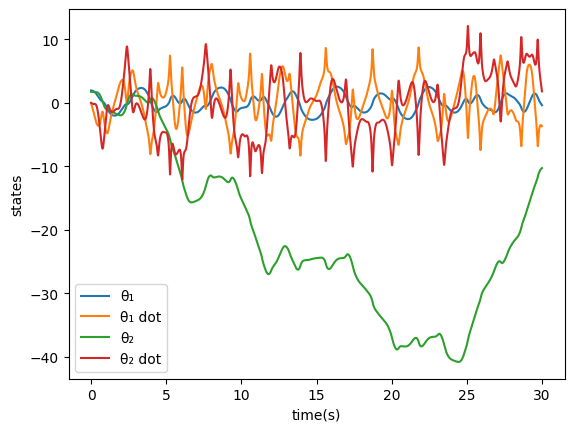

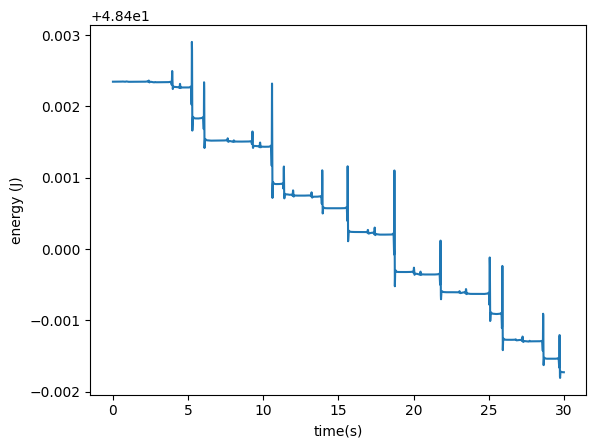

In [10]:
# initial condition
x0 = np.array([pi/1.6, 0., pi/1.8, 0.])

params = Params(
    m1 = 1.0,
    m2 = 1.0,
    L1 = 1.0,
    L2 = 1.0,
    g = 9.8
)

X, E = simulate_explicit(params, double_pendulum_dynamics, forward_euler, x0, dt, tf)
plot_states(t_vec, X)
plot_energy(t_vec, E)

X, E = simulate_explicit(params, double_pendulum_dynamics, midpoint, x0, dt, tf)
plot_states(t_vec, X)
plot_energy(t_vec, E)

X, E = simulate_explicit(params, double_pendulum_dynamics, rk4, x0, dt, tf)
plot_states(t_vec, X)
plot_energy(t_vec, E)

### Part B (10 pts): Implicit Integrators

Explicit integrators work by calling a function with $x_k$ and $\Delta t$ as arguments, and returning $x_{k+1}$ like this:

$$x_{k+1} = f_{explicit}(x_k,\Delta t)$$

Implicit integrators on the other hand have the following relationship between the state at $x_k$ and $x_{k+1}$:

$$f_{implicit}(x_k, x_{k+1}, \Delta t) = 0$$

This means that if we want to get $x_{k+1}$ from $x_k$, we have to solve for a $x_{k+1}$ that satisfies the above equation. This is a rootfinding problem in $x_{k+1}$ (our unknown), so we juse have to use Newton's method.

Here are the three implicit integrators we are looking at, the first being Backward Euler (1st order):

$$f(x_k,x_{k+1},\Delta t) = x_k + \Delta t \cdot \dot{x}_{k+1} - x_{k+1} = 0 \quad \quad \text{Backward Euler}$$

Implicit Midpoint (2nd order)
$$ \begin{align} x_{k+1/2} &= \frac{1}{2}(x_k + x_{k+1})\\\\
    f(x_k,x_{k+1},\Delta t) &= x_k + {\Delta t} \cdot \dot{x}_{k+1/2} - x_{k+1} = 0\quad \quad \text{Implicit Midpoint} \end{align} $$

Hermite Simpson (3rd order)
$$ \begin{align} x_{k+1/2} &= \frac{1}{2}(x_k + x_{k+1}) + \frac{\Delta t}{8}(\dot{x}_k - \dot{x}_{k+1})\\\\
    f(x_k,x_{k+1},\Delta t) &= x_k + \frac{\Delta t}{6} \cdot (\dot{x}_k + 4\dot{x}_{k+1/2} + \dot{x}_{k+1}) - x_{k+1}= 0\quad \quad \text{Hermite-Simpson} \end{align} $$

When you implement these integrators, you will update the functions such that they take in a dynamics function, $x_k$ and $x_{k+1}$, and return the residuals described above. We are NOT solving these yet, we are simply returning the residuals for each implicit integrator that we want to be 0.
<!-- $$ f(x_k,x_{k+1},\Delta t) = x_k + \frac{\\Delta t}{2} \cdot \dot{x}_{k+1/2} - x_{k+1} - x_{k+1}= 0 \quad \quad \text{Hermite-Simpson}$$ -->

In [11]:
# since these are explicit integrators, these function will return the residuals described above
# NOTE: we are NOT solving anything here, simply return the residuals 
def backward_euler(params, dynamics, x1, x2, dt):
    return x1 + dt*dynamics(params, x2) - x2

def implicit_midpoint(params, dynamics, x1, x2, dt):
    x_mid = 0.5*(x1 + x2)
    return x1 + dt*dynamics(params, x_mid) - x2

def hermite_simpson(params, dynamics, x1, x2, dt):
    x_mid = 0.5*(x1 + x2) + (dt/8)*(dynamics(params, x1) - dynamics(params, x2))
    return x1 + (dt/6)*(dynamics(params, x1) + 4*dynamics(params, x_mid) + dynamics(params, x2)) - x2

In [12]:
# TODO
# this function takes in a dynamics function, implicit integrator function, and x1 
# and uses Newton's method to solve for an x2 that satsifies the implicit integration equations
# that we wrote about in the functions above
def implicit_integrator_solve(params, dynamics, implicit_integrator, x1, dt, tol=1e-13, max_iters=10):
    # initialize guess
    x2 = 1*x1

    # make partial implicit integrator
    def partial_implicit_integrator(x):
        return implicit_integrator(params, dynamics, x1, x, dt)
    
    # TODO: use Newton's method to solve for x2 such that residual for the integrator is 0
    # DO NOT USE A WHILE LOOP 
    for i in range(max_iters):
        J = approx_fprime(x2, partial_implicit_integrator)
        x2 = x2 - np.linalg.inv(J) @ implicit_integrator(params, dynamics, x1, x2, dt)

        # TODO: return x2 when the norm of the residual is below tol 
        if np.linalg.norm(implicit_integrator(params, dynamics, x1, x2, dt), 2) < tol:
            return x2
    print("implicit integrator solve failed")

In [13]:
# @testset "implicit integrator check"
dt = 1e-1
x1 = np.array([0.1, 0.2, 0.3, 0.4])

for integrator in [backward_euler, implicit_midpoint, hermite_simpson]:
    print("-----testing {} ------".format(integrator.__name__))
    x2 = implicit_integrator_solve(
        params,
        double_pendulum_dynamics,
        integrator,
        x1,
        dt,
    )
    assert np.linalg.norm(integrator(params, double_pendulum_dynamics, x1, x2, dt), 2) < 1e-10

-----testing backward_euler ------
-----testing implicit_midpoint ------
-----testing hermite_simpson ------


In [14]:
def simulate_implicit(params, dynamics, implicit_integrator, x0, dt, tf, tol=1e-13):
    t_vec = np.arange(0, tf, dt)
    N = len(t_vec)
    X = np.zeros(shape=(N,len(x0)))
    X[0] = x0
    
    # TODO: do a forward simulation with the selected implicit integrator 
    # hint: use your `implicit_integrator_solve` function
    for k in range(N-1):
        X[k+1] = implicit_integrator_solve(
            params,
            dynamics,
            implicit_integrator,
            X[k],
            dt,
        )

    E = [double_pendulum_energy(params,x) for x in X]
    assert len(X)==N
    assert len(E)==N
    return X, E

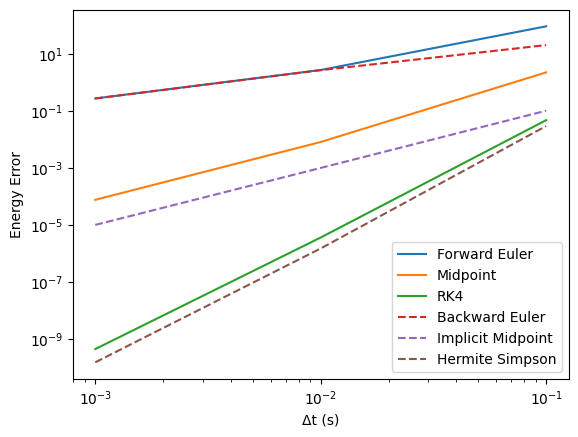

In [15]:
def max_err_E(E):
    E0 = E[0]
    err = np.abs(E - E0)
    return np.max(err)

def get_explicit_energy_error(integrator, dts):
    return np.array([max_err_E(simulate_explicit(params, double_pendulum_dynamics, integrator, x0, dt, tf)[1]) for dt in dts])

def get_implicit_energy_error(integrator, dts):
    return np.array([max_err_E(simulate_implicit(params, double_pendulum_dynamics, integrator, x0, dt, tf)[1]) for dt in dts])

tf = 2.0

# here we compare everything 
dts = [1e-3, 1e-2, 1e-1]
explicit_integrators = [forward_euler, midpoint, rk4]
implicit_integrators = [backward_euler, implicit_midpoint, hermite_simpson]

explicit_data = [get_explicit_energy_error(integrator, dts) for integrator in explicit_integrators]
implicit_data = [get_implicit_energy_error(integrator, dts) for integrator in implicit_integrators]

#plot(dts, hcat(explicit_data...),label = ["Forward Euler" "Midpoint" "RK4"],xaxis=:log10,yaxis=:log10, xlabel = "Δt (s)", ylabel = "Energy Error")
#plot!(dts, hcat(implicit_data...),ls = :dash, label = ["Backward Euler" "Implicit Midpoint" "Hermite Simpson"])
#plot!(legend=:bottomright)

plt.figure()
plt.plot(dts, explicit_data[0], label='Forward Euler')
plt.plot(dts, explicit_data[1], label='Midpoint')
plt.plot(dts, explicit_data[2], label='RK4')
plt.plot(dts, implicit_data[0], label='Backward Euler', linestyle='dashed')
plt.plot(dts, implicit_data[1], label='Implicit Midpoint', linestyle='dashed')
plt.plot(dts, implicit_data[2], label='Hermite Simpson', linestyle='dashed')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Δt (s)')
plt.ylabel('Energy Error')
plt.show()

What we can see above is the maximum energy error for each of the integration methods. In general, the implicit methods of the same order are slightly better than the explicit ones.

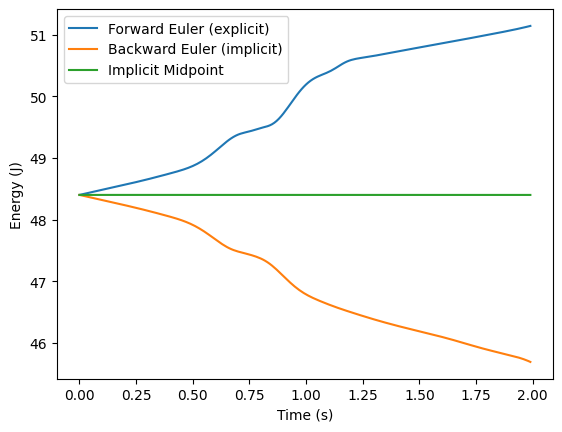

In [16]:
# @testset "energy behavior"
# simulate with all integrators
dt = 0.01
t_vec = np.arange(0, tf, dt)
E1 = simulate_explicit(params,double_pendulum_dynamics, forward_euler, x0, dt, tf)[1]
E2 = simulate_implicit(params,double_pendulum_dynamics, backward_euler, x0, dt, tf)[1]
E3 = simulate_implicit(params,double_pendulum_dynamics, implicit_midpoint, x0, dt, tf)[1]
E4 = simulate_implicit(params,double_pendulum_dynamics, hermite_simpson, x0, dt, tf)[1]
E5 = simulate_explicit(params,double_pendulum_dynamics, midpoint, x0, dt, tf)[1]
E6 = simulate_explicit(params,double_pendulum_dynamics, rk4, x0, dt, tf)[1]

# plot forward/backward euler and implicit midpoint 
#plot(t_vec,E1, label = "Forward Euler (explicit)")
#plot!(t_vec,E2, label = "Backward Euler (implicit)")
#display(plot!(t_vec,E3, label = "Implicit Midpoint",xlabel = "Time (s)", ylabel="Energy (J)"))

plt.figure()
plt.plot(t_vec, E1, label='Forward Euler (explicit)')
plt.plot(t_vec, E2, label='Backward Euler (implicit)')
plt.plot(t_vec, E3, label='Implicit Midpoint')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
plt.show()

# test energy behavior
E0 = E1[0]

assert 2.5  < (E1[-1] - E0) < 3.0
assert -3.0 < (E2[-1] - E0) < -2.5  
assert abs(E3[-1] - E0) < 1e-2
assert abs(E0 - E4[-1]) < 1e-4
assert abs(E0 - E5[-1]) < 1e-1 
assert abs(E0 - E6[-1]) < 1e-4

Another important takeaway from these integrators is that explicit Euler results in unstable behavior (as shown here by the growing energy), and implicit Euler results in artificial damping (losing energy). Implicit midpoint however maintains the correct energy. Even though the solution from implicit midpoint will vary from the initial energy, it does not move secularly one way or the other.